In [1]:
import pandas as pd

# Load the CSV file from the Colab environment
file_path = '/content/stimulus_data.csv'  # Update with your actual file path if needed
data = pd.read_csv(file_path)

# Split the combined column using tab as the delimiter
data_split = data["Trial Number"].str.split("\t", expand=True)

# Rename columns based on inferred structure
data_split.columns = ["Trial Number", "Cue Side", "Target Side", "Correct", "Reaction Time"]

# Convert appropriate columns to numeric where needed
data_split["Trial Number"] = pd.to_numeric(data_split["Trial Number"], errors="coerce")
data_split["Reaction Time"] = pd.to_numeric(data_split["Reaction Time"], errors="coerce")
data_split["Correct"] = data_split["Correct"].map({"True": 1, "False": 0})

# Drop rows with missing or invalid data
data_cleaned = data_split.dropna()

# Display the cleaned data
print("Cleaned Data:")
print(data_cleaned)

# Save the cleaned data back to a CSV file (optional)
output_file_path = '/content/cleaned_stimulus_data.csv'
data_cleaned.to_csv(output_file_path, index=False)

print(f"\nCleaned data has been saved to {output_file_path}.")


Cleaned Data:
   Trial Number Cue Side Target Side  Correct  Reaction Time
0             1     Left       Right        0           1384
1             2     Left       Right        0            695
2             3    Right        Left        0            885
3             4     Left        Left        1            651
4             5    Right       Right        1            762
5             6    Right       Right        1            452
6             7    Right       Right        1            411
7             8    Right        Left        0            379
8             9     Left        Left        1            609
9            10     Left        Left        1            643

Cleaned data has been saved to /content/cleaned_stimulus_data.csv.


In [7]:
# Install required libraries
!pip install pandas matplotlib pyddm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.6/117.6 kB 2.6 MB/s eta 0:00:00


<ipython-input-21-4a2700fece6c>:40: RuntimeWarning: divide by zero encountered in scalar divide
  return norm.pdf(drift_term) / (np.sqrt(decision_time) * boundary)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Fitted Parameters:
Drift Rate: 0.0533
Boundary Separation: 0.1065
Non-decision Time: 0.2466
Bias: 0.5000


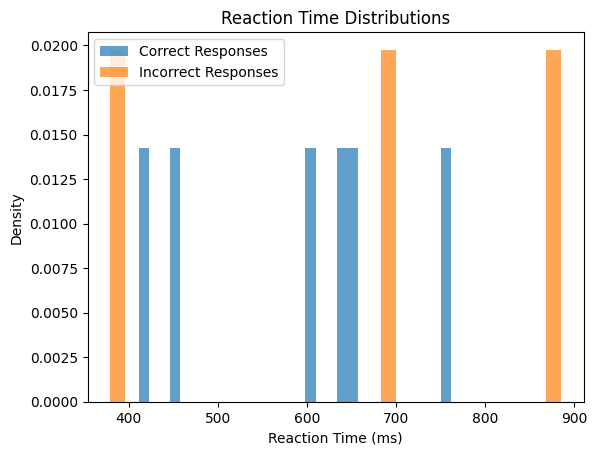

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize

# Step 1: Load the dataset
file_path = '/content/cleaned_stimulus_data.csv'
data = pd.read_csv(file_path)

# Step 2: Preprocess the data
# Encode categorical columns: "Cue Side" and "Target Side"
encoder_cue = LabelEncoder()
encoder_target = LabelEncoder()

data['Cue Side'] = encoder_cue.fit_transform(data['Cue Side'])
data['Target Side'] = encoder_target.fit_transform(data['Target Side'])

# Detect and handle outliers in "Reaction Time" using IQR
q1 = data['Reaction Time'].quantile(0.25)
q3 = data['Reaction Time'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
data = data[(data['Reaction Time'] >= lower_bound) & (data['Reaction Time'] <= upper_bound)]

# Step 3: Define the diffusion model
def diffusion_model(rt, drift_rate, boundary, non_decision_time, bias):
    """
    Probability density function for a simple diffusion model.
    """
    decision_time = rt - non_decision_time
    if decision_time <= 0:
        return 0
    drift_term = (boundary * drift_rate - decision_time * drift_rate**2 / 2) / (np.sqrt(decision_time))
    return norm.pdf(drift_term) / (np.sqrt(decision_time) * boundary)

# Step 4: Define the log-likelihood function
def log_likelihood(params, rts, correct_responses):
    drift_rate, boundary, non_decision_time, bias = params
    likelihoods = []
    for rt, correct in zip(rts, correct_responses):
        p = diffusion_model(rt, drift_rate, boundary, non_decision_time, bias)
        if not correct:
            p = 1 - p  # Flip probability for incorrect responses
        likelihoods.append(p if p > 0 else 1e-10)  # Avoid log(0)
    return -np.sum(np.log(likelihoods))

# Step 5: Fit the diffusion model to the data
rts = data['Reaction Time'].values
correct_responses = data['Correct'].values

# Initial parameter guesses
initial_params = [0.5, 1.0, 0.2, 0.5]  # drift_rate, boundary, non_decision_time, bias
bounds = [(0, None), (0, None), (0, None), (0, 1)]  # Parameter bounds

result = minimize(
    log_likelihood,
    initial_params,
    args=(rts, correct_responses),
    bounds=bounds,
    method='L-BFGS-B'
)

# Extract fitted parameters
fitted_params = result.x
print("Fitted Parameters:")
print(f"Drift Rate: {fitted_params[0]:.4f}")
print(f"Boundary Separation: {fitted_params[1]:.4f}")
print(f"Non-decision Time: {fitted_params[2]:.4f}")
print(f"Bias: {fitted_params[3]:.4f}")

# Step 6: Visualize the reaction time distribution
plt.hist(rts[correct_responses == 1], bins=30, alpha=0.7, label="Correct Responses", density=True)
plt.hist(rts[correct_responses == 0], bins=30, alpha=0.7, label="Incorrect Responses", density=True)
plt.xlabel("Reaction Time (ms)")
plt.ylabel("Density")
plt.legend()
plt.title("Reaction Time Distributions")
plt.show()


# New section

<ipython-input-22-4f7d11f13328>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rts[correct_responses == 1], label="Correct Responses", shade=True, color="blue")
<ipython-input-22-4f7d11f13328>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rts[correct_responses == 0], label="Incorrect Responses", shade=True, color="red")


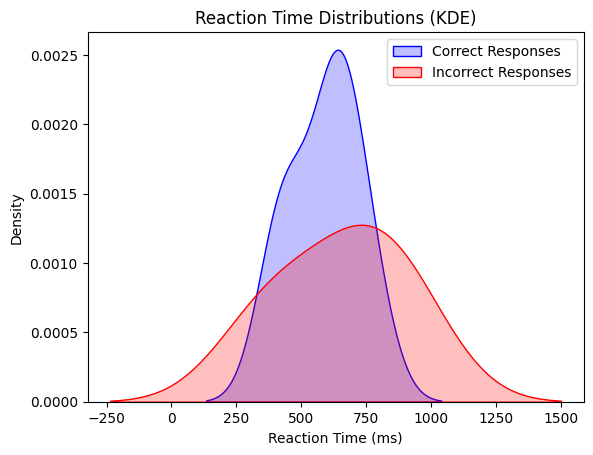

In [22]:
import seaborn as sns

# KDE Plot for Reaction Time Distributions
sns.kdeplot(rts[correct_responses == 1], label="Correct Responses", shade=True, color="blue")
sns.kdeplot(rts[correct_responses == 0], label="Incorrect Responses", shade=True, color="red")

plt.xlabel("Reaction Time (ms)")
plt.ylabel("Density")
plt.title("Reaction Time Distributions (KDE)")
plt.legend()
plt.show()
